In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels.api as sm

# <font face="gotham" color="purple"> Model Specification </font>

So far we have assumed correct **model specification**, if not correctly specified, we are encountering **model specification errors**. Here's the ideal criteria for specifying a model
1. Be able to make logical prediction.
2. Be consistent with theory.
3. Independent variables are uncorrelated with disturbance terms.
4. Parameter constancy.
5. Residuals should be white noise.


However, in practice, model specification errors are almost unavoidable, here are the list of how we might encounter specification errors.

1. Omission of a relevant variable(s).
2. Inclusion of an unnecessary variable(s).
3. Adoption of the wrong functional form.
4. Errors of measurement in data collection process.
5. Incorrect specification of the stochastic error term.
6. Assumption that the error term is normally distributed.

This chapter is exceedingly difficult in multiple independent variable case without linear algebra, we will simply scratch the surface of the topic. 

# <font face="gotham" color="purple"> Omission of A Relevant Variable </font>

Suppose the true relationship is
$$
Y_i = 3 + 4X_2 + 5X_3 + u_i
$$

However we estimate only $X_3$, i.e. the model with omission of $X_2$
$$
\hat{Y} = b_1+b_3X_3
$$

We will do $100000$ rounds of Monte Carlo simulation (might take some time, dial it down if necessary). 

In [155]:
n = 100
beta1, beta2, beta3 = 3, 4, 5
X2 = np.random.rand(n)
X3 = np.random.rand(n)
beta3_hat_list = []
for i in range(100000):

    u = np.random.randn(n)
    Y = beta1 + beta2 * X2 + beta3 * X3 + u
    df = pd.DataFrame(
        np.concatenate(
            (Y[:, np.newaxis], X2[:, np.newaxis], X3[:, np.newaxis]), axis=1
        ),
        columns=["Y", "X2", "X3"],
    )

    X = df["X3"]
    Y = df["Y"]

    X = sm.add_constant(X)  # adding a constant

    model = sm.OLS(Y, X).fit()
    beta3_hat_list.append(model.params[1])

Print the full reports of last round of simulation.

In [156]:
model = sm.OLS(Y, X).fit()
print_model = model.summary()

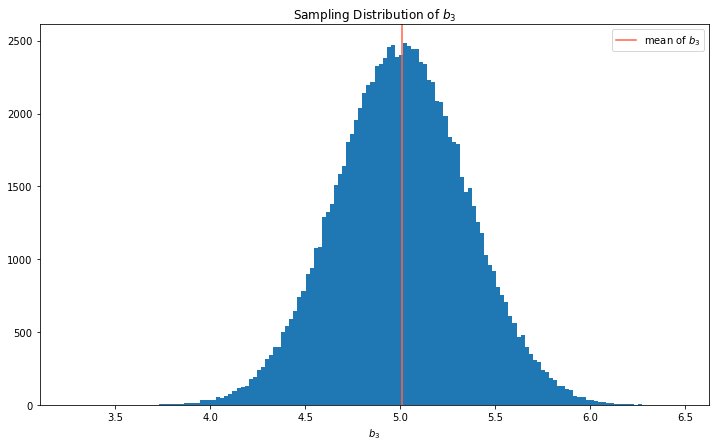

In [157]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(beta3_hat_list, bins=150)
ax.axvline(x=np.mean(beta3_hat_list), color="tomato", label="mean of $b_3$")
ax.set_xlabel("$b_3$")
ax.set_title("Sampling Distribution of $b_3$")
ax.legend()
plt.show()

In [97]:
print("The mean of b3 is {}.".format(np.mean(beta3_hat_list)))

The mean of b3 is 5.998913199703797.


With $100000$ rounds of simulation, we could easily notice the sample distribution is biased, and mean of $b_3$ is far from true value $5$. We will demonstrate why this is the case without linear algebra.

We have shown in the second chapter, that estimator $b_3$ in a two-independent variable case is
$$
b_{3}=\frac{\operatorname{Cov}\left(X_{3}, Y\right) \operatorname{Var}\left(X_{2}\right)-\operatorname{Cov}\left(X_{2}, Y\right) \operatorname{Cov}\left(X_{3}, X_{2}\right)}{\operatorname{Var}\left(X_{3}\right) \operatorname{Var}\left(X_{2}\right)-\left[\operatorname{Cov}\left(X_{3}, X_{2}\right)\right]^{2}}
$$

However, without being aware the omission of $\beta_2$, we end up using estimator
$$
b_{3}=\frac{\operatorname{Cov}\left(X_{3}, Y\right)}{\operatorname{Var}\left(X_{3}\right)}
$$
Substitute $Y$ by its true relationship can share some insight
$$
\begin{aligned}
b_{3} &=\frac{\operatorname{Cov}\left(X_{3}, Y\right)}{\operatorname{Var}\left(X_{3}\right)}=\frac{\operatorname{Cov}\left(X_{3},\left[\beta_{1}+\beta_{2} X_{2}+\beta_{3} X_{3}+u\right]\right)}{\operatorname{Var}\left(X_{3}\right)} \\
&=\frac{1}{\operatorname{Var}\left(X_{3}\right)}\left[\operatorname{Cov}\left(X_{3}, \beta_{1}\right)+\operatorname{Cov}\left(X_{3}, \beta_{2} X_{2}\right)+\operatorname{Cov}\left(X_{3}, \beta_{3} X_{3}\right)+\operatorname{Cov}\left(X_{3}, u\right)\right] \\
&=\frac{1}{\operatorname{Var}\left(X_{3}\right)}\left[0+\beta_{2} \operatorname{Cov}\left(X_{2}, X_3\right)+\beta_{3} \operatorname{Var}\left(X_{3} \right)+\operatorname{Cov}\left(X_{3}, u\right)\right] \\
&=\beta_{3}+\beta_{2} \frac{\operatorname{Cov}\left(X_{2}, X_{3}\right)}{\operatorname{Var}\left(X_{3}\right)}+\frac{\operatorname{Cov}\left(X_{3}, u\right)}{\operatorname{Var}\left(X_{3}\right)}
\end{aligned}
$$

This is the relationship of $b_3$ and $\beta_3$ when $b_2$ is omitted in the model. Whether upward biased or downward biased, it depends on the sign of $\beta_2$ and covariance of $X_2$ and $X_3$. And it's safe to assume $\operatorname{Cov}(X_3, u )=0$.

As you can see now the biased term is 
$$
\beta_{2} \frac{\operatorname{Cov}\left(X_{2}, X_{3}\right)}{\operatorname{Var}\left(X_{3}\right)}
$$
Therefore $b_3$ can be unbiased after all on condition that $\operatorname{Cov}(X_2, X_3)=0$, however this is extremely unlikely. 

In general, omission of relevant variables also cause invalid hypotheses test, however we'll skip it entirely.

# <font face="gotham" color="purple">  Inclusion Of An Unnecessary Variable </font>

Now again suppose the true relationship is
$$
Y_i = 3 + 4X_2  + u_i
$$

However we include an unnecessary variable $X_3$, i.e.
$$
\hat{Y} = b_1+b_2X_2 + b_3X_3
$$

In [149]:
n = 100
beta1, beta2 = 3, 4
X2 = np.random.rand(n)
X3 = np.random.rand(n)
beta2_hat_list = []
for i in range(100000):

    u = np.random.randn(n)
    Y = beta1 + beta2 * X2 + u
    df = pd.DataFrame(
        np.concatenate(
            (Y[:, np.newaxis], X2[:, np.newaxis], X3[:, np.newaxis]), axis=1
        ),
        columns=["Y", "X2", "X3"],
    )

    X = df[["X2", "X3"]]
    Y = df["Y"]

    X = sm.add_constant(X)  # adding a constant

    model = sm.OLS(Y, X).fit()
    beta2_hat_list.append(model.params[1])

Print the full reports of last round of simulation.

In [150]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     87.05
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           2.25e-22
Time:                        11:26:42   Log-Likelihood:                -146.33
No. Observations:                 100   AIC:                             298.7
Df Residuals:                      97   BIC:                             306.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6164      0.271      9.646      0.0

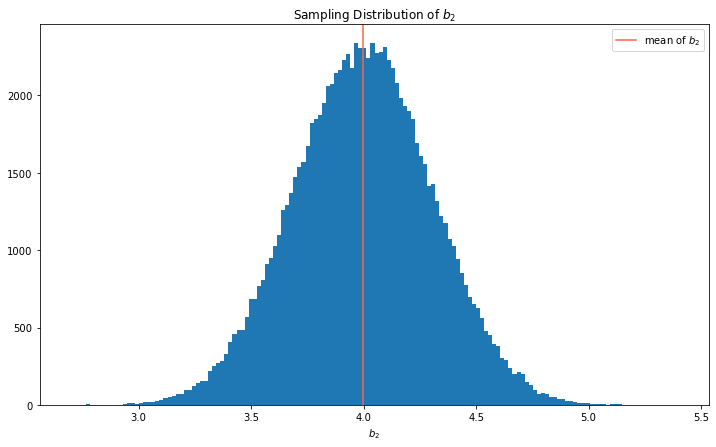

In [151]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(beta2_hat_list, bins=150)
ax.axvline(x=np.mean(beta2_hat_list), color="tomato", label="mean of $b_2$")
ax.set_xlabel("$b_2$")
ax.set_title("Sampling Distribution of $b_2$")
ax.legend()
plt.show()

It turns out that the $b_2$ is not biased after all! However, let's compare with $b_2$'s sampling distribution which is from correct specification.

In [133]:
beta2_hat_list_correct = []
for i in range(100000):

    u = np.random.randn(n)
    Y = beta1 + beta2 * X2 + u
    df = pd.DataFrame(
        np.concatenate((Y[:, np.newaxis], X2[:, np.newaxis]), axis=1),
        columns=["Y", "X2"],
    )

    X = df["X2"]
    Y = df["Y"]

    X = sm.add_constant(X)  # adding a constant

    model = sm.OLS(Y, X).fit()
    beta2_hat_list_correct.append(model.params[1])

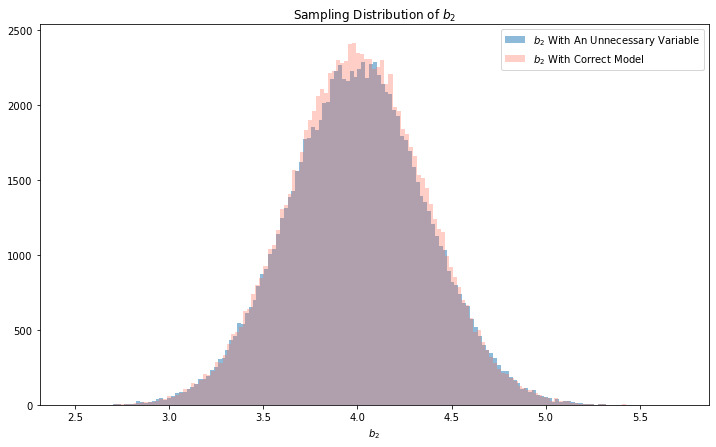

In [146]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(beta2_hat_list, bins=150, alpha=0.5, label="$b_2$ With An Unnecessary Variable")
ax.hist(
    beta2_hat_list_correct,
    bins=150,
    alpha=0.3,
    color="tomato",
    label="$b_2$ With Correct Model",
)
ax.set_xlabel("$b_2$")
ax.set_title("Sampling Distribution of $b_2$")
ax.legend()
plt.show()

If you take a closer look at the distribution, they are actually different, the $b_2$ estimated by correct model has a more concentrated distribution, i.e. the middle area is higher, in contrast the $b_2$ estimated by incorrectly specified model has fatter tails. We can check their standard deviation.

In [135]:
np.std(beta2_hat_list)

0.3638018676170749

In [136]:
np.std(beta2_hat_list_correct)

0.35998511144681705

To remind you why this is the case, here we reproduce the formula of standard deviation of $b_2$ in two independent variable regression
$$
\sigma_{b_{2}}^{2}=\frac{\sigma_{u}^{2}}{n \operatorname{Var}\left(X_{2}\right)} \frac{1}{1-r_{X_{2} X_{3}}^{2}}
$$
$\sigma_{b_{2}}^{2}$ is enlarged by a the correlation $r^2_{X_2X_3}$, which is why the blue color distribution has fatter tails.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<i><b> Asymmetry of Specification Errors</b><br>
The asymmetry of two types of specification errors: adding irrelevant variables still grant us unbiased and consistent estimate though standard errors are inflated, however excluding a relevant variable would cause bias and inconsistency. <br><br>
    
Does it suggest that we should err on the side of adding irrelevant variables? In the field of econometrics, not really. The _best practice_ is to include only explanatory variables that, on theoretical grounds, directly influence the dependent variable and that are not accounted for by other
included variables.
</div>

# <font face="gotham" color="purple"> Tests of Specification Errors </font>

Truth to be told, we will never be sure how the observed data were generated, but we can make educated guess about specification errors with the help of statistical tests. 

## <font face="gotham" color="purple"> Tests of Overfitted Models </font>

The most convenient methods of detecting unnecessary variables are $F$ and $t$-tests, take a look the regression results with unnecessary variable, the $X_3$ has a p-value of $ 0.757$, we can surely deem $X_3$ as unnecessary.

The purist econometrician objects the method of adding independent variables iteratively by testing $t$, however data scientists have a more practical view that they believe the model should be driven by data, i.e. the model should learn the data and express the data.

## <font face="gotham" color="purple"> Tests of Underfitted Models </font>

To detect an underfitting model is more than looking at $t$'s or $F$'s, we also need to investigate the broad features of results, such $R^2$, signs of estimates, residuals and other relevant tests. 

### <font face="gotham" color="purple"> Investigating Residuals </font>

Here we reproduce the underfitted model example. The unfitted model obviously has larger dispersion of residual. 

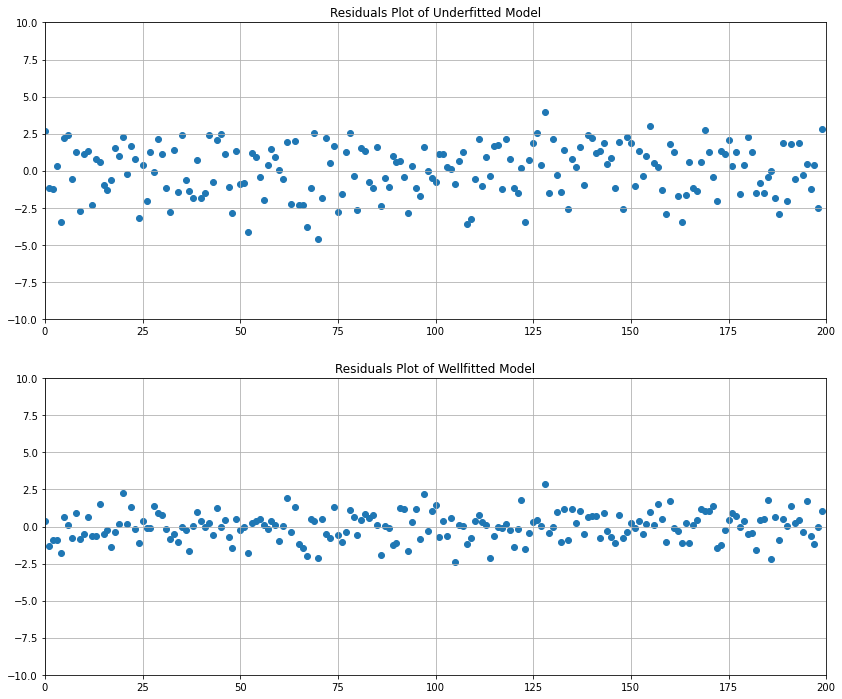

In [185]:
n = 200
beta1, beta2, beta3 = 3, 4, 5
X2 = np.random.rand(n)
X3 = np.random.rand(n)

u = np.random.randn(n)
Y = beta1 + beta2 * X2 + beta3 * X3 + u
df = pd.DataFrame(
    np.concatenate((Y[:, np.newaxis], X2[:, np.newaxis], X3[:, np.newaxis]), axis=1),
    columns=["Y", "X2", "X3"],
)

X_underfit = df["X2"]
Y = df["Y"]
X_underfit = sm.add_constant(X_underfit)
model_underfit = sm.OLS(Y, X_underfit).fit()

X_wellfit = df[["X2", "X3"]]
X_wellfit = sm.add_constant(X_wellfit)
model_wellfit = sm.OLS(Y, X_wellfit).fit()


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))
ax[0].scatter(np.arange(len(model_underfit.resid)), model_underfit.resid)
ax[0].set_xlim(0, n)
ax[0].set_ylim(-10, 10)
ax[0].grid()
ax[0].set_title("Residuals Plot of Underfitted Model")

ax[1].scatter(np.arange(len(model_wellfit.resid)), model_wellfit.resid)
ax[1].set_xlim(0, n)
ax[1].set_ylim(-10, 10)
ax[1].grid()
ax[1].set_title("Residuals Plot of Wellfitted Model")

plt.show()

### <font face="gotham" color="purple">Ramsey’s RESET Test</font>

Ramsey's **Regression Equation Specification Error Test** (RESET) is general test for specification error.  

In [216]:
reset_results = sm.stats.diagnostic.linear_reset(model_underfit)

In [217]:
print(reset_results.summary())

<Wald test (chi2): statistic=[[2.89568024]], p-value=0.23507747893517628, df_denom=2>


### <font face="gotham" color="purple">Lagrange Multiplier (LM) Test for Adding Variables</font>

# <font face="gotham" color="purple"> $AIC$ and $SIC$ </font>

Besides $R^2$ and $\bar{R}^2$ that were discussed in the first two chapters. Here are another two statistics for model selection: **Akaike’s Information Criterion** (AIC) and **Bayesian information criterion** (BIC).

Both statistics are standard output printed in the estimation report, you can check the report above.

## <font face="gotham" color="purple">**Akaike’s Information Criterion**</font>

$AIC$ imposes stronger penalty than $\bar{R}^2$. The formula is 
$$
\mathrm{AIC}=e^{2 k / n} \frac{\sum e_{i}^{2}}{n}=e^{2 k / n} \frac{\mathrm{RSS}}{\mathrm{n}}
$$

$AIC$ is commonly used in time series model to determine the lag length, where $n$ is number of observations and $k$ is the number of independent variables.

## <font face="gotham" color="purple">**Bayesian Information Criterion**</font>

$BIC$ imposes even harsher penalty than $AIC$
$$
\mathrm{SIC}=n^{k / n} \frac{\sum e^{2}_i}{n}=n^{k / n} \frac{\mathrm{RSS}}{n}
$$

As you can see from their formula, both criteria prefer smaller result, because $RSS$ is smaller. 

We can plot the $AIC$ and $BIC$ as functions of number of variables, it is easy to see that $BIC$ has higher penalty, however it doesn't meant $BIC$ is superior than $AIC$.

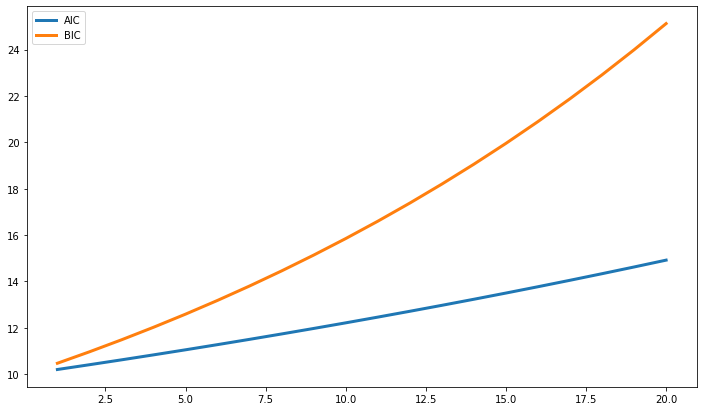

In [232]:
n = 100
k = np.arange(1, 21)
RSS = 1000


def aic(RSS):
    return np.exp(2 * k / n) * RSS / n


def bic(RSS):
    return n ** (k / n) * RSS / n


aic = aic(RSS)
bic = bic(RSS)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(k, aic, label="AIC", lw=3)
ax.plot(k, bic, label="BIC", lw=3)
ax.legend()
plt.show()

Also, both these criteria are commonly used in data science to compare **in-sample** and **out-of-sample** performance.

# <font face="gotham" color="purple"> Measurement Error </font>

Keep in mind that any data might have certain extent of measurement error, either due to mis-recording or mis-communication. Most of time we assume the data are correctly measured, but that's more precise, we will discuss what consequences measurement error can cause with examples of simple linear regression.

## <font face="gotham" color="purple"> Measurement Error in Independent Variables </font>

Assume the true relationship is
$$
Y_{i}=\beta_{1}+\beta_{2} Z_{i}+v_{i}
$$
However due to some technical reason, we are unable to precisely measure $Z_i$,what we can observe is $X_i$ which has a relationship with $Z_i$
$$
X_{i}=Z_{i}+w_{i}
$$
Combine them
$$
Y_{i}=\beta_{1}+\beta_{2}\left(X_{i}-w_{i}\right)+v_{i}=\beta_{1}+\beta_{2} X_{i}+v_{i}-\beta_{2} w_{i}
$$

The disturbance term $v_i-\beta_2w_i$ is a composite term and also $X_i$ not independent from composite disturbance term, because of common part $w_i$.

Recall the estimator of $b_2$ can be decomposed as
$$
b_{2}=\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}=\beta_{2}+\frac{\operatorname{Cov}(X, u)}{\operatorname{Var}(X)}
$$
however in this case $X_i$ and $u_i$ are not independent, we can expand covariance expression.
$$
\operatorname{Cov}(X, u)= \operatorname{Cov}((Z+w),(v-\beta_2w)) = \operatorname{Cov}(Z,v)+\operatorname{Cov}(w,v)+\operatorname{Cov}(Z,-\beta_2w)+\operatorname{Cov}(w,-\beta_2w) = -\beta_2\sigma_w^2
$$
Also expand variance at the denominator 
$$
\operatorname{Var}(X)=\operatorname{Var}(Z+w)=\operatorname{Var}(Z)+\operatorname{Var}(w)+2\operatorname{Cov}(Z,w)=\sigma_Z^2+\sigma_w^2
$$
Therefore
$$
b_{2}=\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}=\beta_{2}-\frac{\beta_2\sigma_w^2}{\sigma_Z^2+\sigma_w^2}
$$

This is how measurement error will affect estimates theoretically, the $b_2$ will be always biased downward.

We can show this with Monet Carlo simulation

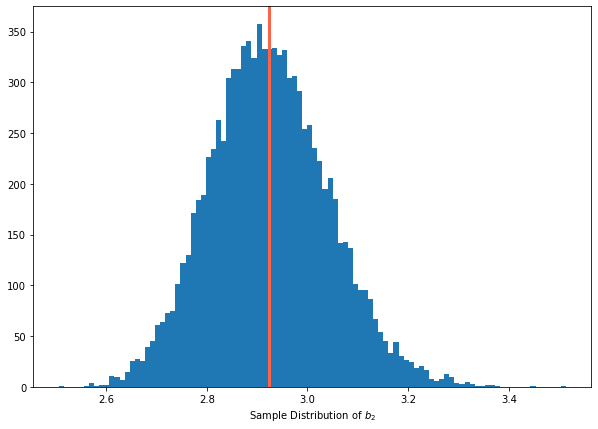

In [261]:
Z = np.arange(1, 21)
b2_array = []
for i in range(10000):
    w = np.random.randn(20)
    v = np.random.randn(20)
    X = Z + w
    beta1, beta2 = 2, 3
    Y = beta1 + beta2 * Z + v
    b2_array.append(sp.stats.linregress(X, Y)[0])
fig, ax = plt.subplots(figsize=(10, 7))
n, bins, patches = ax.hist(b2_array, bins=100)
ax.axvline(x=np.mean(b2_array), lw=3, color="tomato")
ax.set_xlabel("Sample Distribution of $b_2$")
plt.show()

With $10000$ times of simulations, the estimates are always less than $3$, which is biased downward.

## <font face="gotham" color="purple"> Measurement Error in Dependent Variables </font>

If the true relationship is 
$$
Q_i = \beta_1+\beta_2X_1+v_i
$$
However $Q_i$ cannot be precisely recorded, instead $Y_i$ is recorded, where
$$
Y_i = Q_r + r_i
$$
The true relationship can rewritten as
$$
Y_i= \beta_1+\beta_2X_i+v_i+r_i 
$$

But note that $X_i$ is note affected, so OLS still provide unbiased and consistent estimates.

The composite disturbance term increase the the population variance of slope coefficient
$$
\sigma_{b_{2}}^{2}=\frac{\sigma_{v}^{2}+\sigma_{r}^{2}}{n \operatorname{Var}(X)}
$$

# <font face="gotham" color="purple"> Instrumental Variables Regression </font>

We have discussed how $X$ can be correlated with disturbance term $u$, either due to omitted variables or measurement errors in independent variables. In next chapter we will also see how simultaneous equations model also cause interdependence between $X$ and $u$.

Here we will discuss a general method **Instrumental Variable** (IV) Regression to obtain consistent estimator when $X$ is correlated with $u$. The idea of this method is extract the part of $X$ that is not correlated with $u$ and extraction is called IV, which can be used in obtaining consistent estimators.

Consider the model
$$
Y_{i}=\beta_{1}+\beta_{2} X_{i}+u_{i}
$$
where $X_i$ and $u_i$ are correlated, OLS estimators are inconsistent. IV method requires identify an instrument $Z_i$, which is correlated with $X_i$, but not with $u_i$. 

For the time being, we define that variables that correlated with disturbance term are called **endogenous variable**, otherwise called **exogenous variable**. In the context of simultaneous equation, we will come back to these terms again.

To be a valid instrument, two conditions needs to be satisfied
$$
\begin{aligned}
&\operatorname{Cov}\left(Z_{i}, X_{i}\right) \neq 0 \\
&\operatorname{Cov}\left(Z_{i}, u_{i}\right)=0
\end{aligned}
$$
The philosophy of IV is to use $Z_i$ to capture the exogenous part of movements of $X_i$.

## <font face="gotham" color="purple"> Two Stage Least Squares </font>

If both condition satisfied, the estimation process with IV is called **Two Stage Least Square** (2SLS).

_$1$st Stage_: decomposes $X$ into two components: a problematic component that may be correlated with the regression error and another problem-free component that is uncorrelated with the disturbance term. For simple linear regression model, the first stage begins with a regression model that links $X$ and $Z$

$$
X_i = \alpha_1 + \alpha_2Z_i + v_i
$$

The problem-free component is the estimated values of $\hat{X}_i= a_1 + a_2 Z_i$, which is uncorrelated with $u_i$.

_$2$nd Stage_: uses the problem-free component to estimate $\beta_2$.

In the context of simple linear regression, regress $Y_i$ on $\hat{X}_i$ using OLS. The resulting estimators are 2SLS estimators.

If you can derive the formula of IV estimator, you won't need to go through these two steps. We can demonstrate how IV estimator of $\beta_2$ is derived. We start from the covariance of $Z_i$ and $Y_i$
$$
\operatorname{Cov}(Z_i, Y_i) = \operatorname{Cov}(Z_i, \beta_{1}+\beta_{2} X_{i}+u_{i}) =  \operatorname{Cov}(Z_i, \beta_{0}) + \operatorname{Cov}(Z_i, \beta_{2} X_{i}) +  \operatorname{Cov}(Z_i, u_{i}) =\beta_{2} \operatorname{Cov}(Z_i,  X_{i})
$$

Rearrange the result, denote estimator as $b_2$
$$
b_2^{\mathrm{IV}} = \frac{\operatorname{Cov}(Z_i, Y_i)}{\operatorname{Cov}(Z_i,  X_{i})}
$$

To compare OLS and IV estimator for simple linear regression, here we reproduce the $b_2$ estimator of OLS
$$
b_{2}^{\mathrm{OLS}}=\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}=\frac{\operatorname{Cov}(X, Y)}{\operatorname{Cov}(X, X)}
$$

IV estimator is obtained by replacing an $X$ both in nominator and denominator.
$$
\begin{aligned}
b_{2}^{\mathrm{IV}} &=\frac{\operatorname{Cov}(Z, Y)}{\operatorname{Cov}(Z, X)}=\frac{\operatorname{Cov}\left(Z,\left[\beta_{1}+\beta_{2} X+u\right]\right)}{\operatorname{Cov}(Z, X)} \\
&=\frac{\operatorname{Cov}\left(Z, \beta_{1}\right)+\operatorname{Cov}\left(Z, \beta_{2} X\right)+\operatorname{Cov}(Z, u)}{\operatorname{Cov}(Z, X)} \\
&=\beta_{2}+\frac{\operatorname{Cov}(Z, u)}{\operatorname{Cov}(Z, X)}
\end{aligned}
$$

It tell that the accuracy of $b_{2}^{\mathrm{IV}}$ depends on relative quantity of covariance. In large sample, we expect IV estimator to be consistent
$$
\operatorname{plim} b_{2}^{\mathrm{IV}}=\beta_{2}+\frac{\operatorname{plim} \operatorname{Cov}(Z, u)}{\operatorname{plim} \operatorname{Cov}(Z, X)}=\beta_{2}+\frac{0}{\sigma_{z x}}=\beta_{2}
$$

We can also compare variance of OLS and IV from simple linear regression
$$
\sigma_{b_{2}^{\mathrm{IV}}}^{2}=\frac{\sigma_{u}^{2}}{n \sigma_{X}^{2}} \times \frac{1}{r_{X Z}^{2}}\\
\sigma_{b_{2}^{\mathrm{OLS}}}^{2}=\frac{\sigma_{u}^{2}}{n \sigma_{X}^{2}}
$$
The greater the correlation between $X$ and $Z$, the smaller will be the variance of $\sigma_{b_{2}^{\mathrm{IV}}}^{2}$.

We will walk through a numerical example in next chapter, after discussing the identification issue.